In [1]:
# import os

# # change JAX GPU memory preallocation fraction
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

# from jax import config
# config.update("jax_enable_x64", True)

# import jax

# !nvidia-smi --query-gpu=gpu_name --format=csv,noheader

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import numpy as np
from tqdm import tqdm
from jax import lax
from jax.typing import ArrayLike
from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

import alpaga

from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
# Set up a simulation box -- now in BORG settings
L = 250 #500 #4000 #  # resolution
N = 128 # 128

#Lbox = (L, L, 5500)
Lbox = (L, L, 4000)
Nmesh = (N, N, 512)

coord_obs = (L // 2, L // 2, 0)
coord_obsN = (N // 2, N // 2, 0)

# specifying los_coords will ask the Box to calculate the coordinates, which takes a while.
# if you already have the coordinates, save them and set `los_coords=None`
#box = alpaga.simgrid.Box(Lbox, Nmesh, coord_obs)#, los_coords=coord_obsN)

#los_indices = jnp.load("los_indices.npy")
#los_indices = box.los_indices


# Set the simulation parameters
a_init = 0.01
a_final = 1.0
lpt_order = 2
lightcone = True

# simulation box physical terms (comoving grid)
#Nx,Ny,Nz = box.Nmesh
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]

# tomographic bin means
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])
zstd = 0.14

In [6]:
los_indices = jnp.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))
#np.save("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512"%(N), los_indices)

In [7]:
los_indices.nbytes / 1e9

0.201326592

In [8]:
from lemur.utils import *

# make global
spherical_cap, costheta_1 = get_pixel_geometry(Nmesh, coord_obsN)

In [9]:
simulator_args = dict(
                Lbox = Lbox,
                Nmesh = Nmesh,
                coord_obs = (L // 2, L // 2, 0),
                los_indices=los_indices,
                zmeans=z_means_analysis,
                zstds=jnp.ones(z_means_analysis.shape[0])*zstd,
                spherical_cap=spherical_cap,
                costheta_1=costheta_1,
                lpt_order=lpt_order
)

In [10]:
@partial(jax.jit, static_argnums=(2,))
def simulator(seed, θ,
             simulator_args=simulator_args
             ):
    
    omegam,sigma8 = θ
    cosmo = cosmology.CosmologicalParameters(sigma8=sigma8, Omega_m=omegam)

    Nmesh = simulator_args["Nmesh"]
    Lbox = simulator_args["Lbox"]
    zmeans = simulator_args["zmeans"]
    zstds = simulator_args["zstds"]

    # try creating the box internally
    box = alpaga.simgrid.Box(Lbox, Nmesh, coord_obs)
    Nx,Ny,Nz = box.Nmesh
    
    # Generate a white noise field
    wn = alpaga.simulate.generate_white_noise(box, seed)

    # density field
    delta_los = simulate.full_forward(
        wn,
        box,
        cosmo,
        a_init,
        a_final,
        "density",
        lpt_order,
        lightcone=True,
        pk_calculator="nonlinear"
    
    )
    
    #los_indices = np.load("/data101/makinen/lemur_sims/los_indices_N_%d_Nz_512.npy"%(N))
    los_indices = simulator_args["los_indices"]

    #@partial(jax.jit, static_argnames=["delta"])
    @jax.jit
    def all_los(single_index, delta=delta_los):
        """
        helper function to map los_indices to slice through
        the delta box (will integrate in codebase soon)
        """
    
        def index_me(ind, delta=delta): # vmap over Nz
            return delta[tuple(ind)]    
    
        return jax.vmap(index_me, in_axes=(0,))(single_index)
        
    delta_los = jax.vmap(all_los)(los_indices).reshape(Nx,Ny,Nz)

    # now do convergence nonsense

    # the corresponding scale factor grid changes with cosmology
    # simulation box physical terms (comoving grid)
    chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]
    a_grid = background.compute_scale_factor_at_comoving_distance(chi_grid, cosmo)
    z_grid = a_to_z(a_grid)
    
    lensing_factor = 1.5 * cosmo.Omega_m * (cosmo.h * 100.)**2 / constants.c**2
    chi_source = chi_grid[-1]
    kernel = utils.calculate_lensing_efficiency(chi_grid, chi_source) / a_grid
    
    # kernel becomes r / costheta; integrate only up to spherical cap rmax
    delta_los *= simulator_args["spherical_cap"]
    delta_los *= simulator_args["costheta_1"]

    # Convergence field in tomographic bins

    # redshift bin weights vmap
    dr = box.Lbox[-1] / box.Nmesh[-1]

    #@partial(jax.jit, static_argnames=["delta_los"])
    @jax.jit
    def get_tomobin(zmean, zstd, delta_los=delta_los):
        
        ws = get_weights_in_chi(z_grid, 
                                a_grid,
                                chi_grid,
                                zmean, 
                                std=zstd
                               ) 
        
        def fn(k_ij): #=ws):
            """
            k_ij: 3D field slice k[i,j,:]
            weights: (Nz,) weight array
            """
            return jnp.sum(k_ij * ws * kernel * Jacobian(z_grid, cosmo) * dr) 
        
        kappa_tomo = jax.vmap(jax.vmap(fn, in_axes=(0,)), in_axes=(1,))(delta_los)
        kappa_tomo -= jnp.mean(kappa_tomo)

        return kappa_tomo * lensing_factor

    

    return jnp.squeeze(jax.vmap(get_tomobin)(zmeans, zstds))

In [11]:
θ_fid = jnp.array([0.3, 0.800])

In [12]:
%time jax.block_until_ready(simulator(20, θ_fid))
%time kappatest = jax.block_until_ready(simulator(20, θ_fid))

2024-04-27 21:08:55.849048: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.535 = s64[16384,512,1]{2,1,0} slice(s64[16384,512,3]{2,1,0} %constant.255), slice={[0:16384], [0:512], [0:1]}, metadata={op_name="jit(simulator)/jit(main)/vmap(jit(all_los))/slice[start_indices=(0, 0, 0) limit_indices=(16384, 512, 1) strides=(1, 1, 1)]" source_file="/tmp/ipykernel_1836162/2515812703.py" source_line=47}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-04-27 21:09:14.934623: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 20.08573191s
Constant folding an i

CPU times: user 6min 13s, sys: 1min 15s, total: 7min 28s
Wall time: 1min 23s
CPU times: user 79.7 ms, sys: 0 ns, total: 79.7 ms
Wall time: 117 ms


In [19]:
%time kappatest = jax.block_until_ready(simulator(20, jnp.array([0.3, 0.8])))

CPU times: user 92 ms, sys: 1.02 ms, total: 93 ms
Wall time: 128 ms


In [20]:
kappa_extr = kappatest[1, ...].max()
kappa_extr

Array(0.02782947, dtype=float64)

/tmp/ipykernel_1836162/1360875464.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


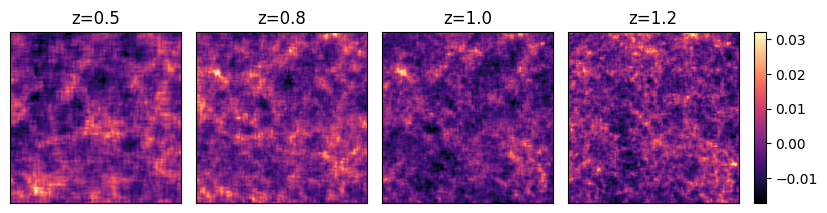

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

for i,z in enumerate(z_means_analysis):
    ax = grid[i]
    im = ax.imshow(kappatest[i], 
                    #vmin=-kappa_extr, 
                    #vmax=kappa_extr, 
                   interpolation='spline36',
                   cmap='magma'
                  )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("z=%.1f"%(z))
    
# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

## set up moped for the problem

In [22]:
### ------------- IMNN PARAMETERS -------------
#θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
#θ_fid = jnp.array([0.5, 0.900])
θ_fid = jnp.array([0.5, 0.9])
#δθ = 2*jnp.array([0.0115, 0.015])

δθ = 2*jnp.array([0.0215, 0.015]) # double the derivative step size

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 3000
n_d = 1000

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.4785 0.9   ]
 [0.5    0.885 ]
 [0.5215 0.9   ]
 [0.5    0.915 ]]


In [23]:
θ_der.shape

(4, 2)

In [24]:
import jax.random as jrnd

key1 = jrnd.PRNGKey(44)
key2 = jrnd.PRNGKey(45)

fid_keys = jnp.arange(n_s)
derv_keys = jnp.arange(n_d) + 8000



#derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0)

In [25]:
key1[0]

Array(0, dtype=uint32)

In [26]:
# now make a bunch of simulations (batch in size 50)
batch = 2
input_shape = (4,N,N)


# first do derivative
derv = []

for i in tqdm(range(n_d // batch)):

    numderv = jax.vmap(simulator)(
        jnp.repeat(derv_keys[i*batch:(i+1)*batch], θ_der.shape[0], axis=0),
        jnp.tile(θ_der, (batch, 1))).reshape(
            (batch, 2, n_params) + input_shape)

    derv.append(numderv)

derv = jnp.concatenate(derv)

  0%|          | 0/500 [00:00<?, ?it/s]2024-04-27 21:11:14.400694: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  %slice.535 = s64[16384,512,1]{2,1,0} slice(s64[16384,512,3]{2,1,0} %constant.365), slice={[0:16384], [0:512], [0:1]}, metadata={op_name="jit(simulator)/jit(main)/vmap(jit(all_los))/slice[start_indices=(0, 0, 0) limit_indices=(16384, 512, 1) strides=(1, 1, 1)]" source_file="/tmp/ipykernel_1836162/2515812703.py" source_line=47}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-04-27 21:11:28.399471: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation 

In [19]:
derv.shape

(1000, 2, 2, 4, 128, 128)

In [21]:
128 / 7

18.285714285714285

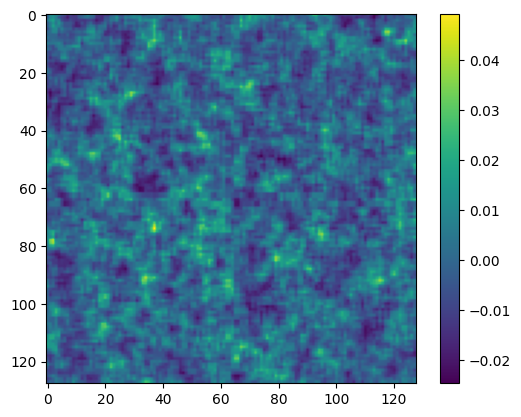

In [20]:
plt.imshow(derv[0, 0, 0, 3, ...])
plt.colorbar()

In [27]:
outdir = "/data101/makinen/lemur_sims/first_analysis/"
jnp.save(outdir + "derv_bigstep_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10), derv)

In [22]:
outdir = "/data101/makinen/lemur_sims/first_analysis/"
derv = jnp.load(outdir + "derv_tomo_L_%d_N_%d_Nz_512_LPT%d_Om_%d.npy"%(L, N, lpt_order, θ_fid[0]*10))

In [34]:
del derv

In [30]:
lpt_order

2

In [35]:
# now make a bunch of simulations (batch in size 50)
batch = 2
input_shape = (4,N,N)

# now fiducial
fid = jnp.zeros((n_s,) + (input_shape))

# would this compile faster if I just broadcasted the vmap over copies of θ_fid 
mysim = lambda s: simulator(s, θ=θ_fid)
                            
for i in tqdm(range(n_s // batch)):
    
    #sims = jax.vmap(simulator)(fid_keys[i*batch:(i+1)*batch], jnp.ones((batch, θ_fid.shape[0]))*θ_fid)
    #sims = jax.vmap(mysim)(fid_keys[i*batch:(i+1)*batch])
    #fid.append(sims)

    fid = fid.at[i*batch:(i+1)*batch].set(
                    jax.vmap(simulator)(fid_keys[i*batch:(i+1)*batch], jnp.ones((batch, θ_fid.shape[0]))*θ_fid)
    )

#fid = jnp.concatenate(fid)

100%|██████████| 1500/1500 [05:15<00:00,  4.76it/s]


In [25]:
fid.shape

(3000, 4, 128, 128)

In [36]:
outdir = "/data101/makinen/lemur_sims/first_analysis/"
jnp.save(outdir + "fid_new_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10), fid)

In [33]:
derv = jnp.load(outdir + "derv_new_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d.npy"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10))

In [34]:
fid.shape, derv.shape

((3000, 4, 128, 128), (250, 2, 2, 4, 128, 128))

In [30]:
lpt_order

0

### now take $C_\ell$s

In [94]:
num_tomo = 3

def indices_vector(num_tomo=num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

indices = jnp.array(indices_vector())
indices += 1
indices

Array([[1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 3],
       [3, 3]], dtype=int64)

In [26]:
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lbox[2] / Nmesh[2]
chi_source = chi_grid[-1]

Nx,Ny,Nz = Nmesh

end = 10 #64
skip = 1
#num_bins = Nx // 2 // 4
num_bins = jnp.ones(Nx//2)[:end:skip].shape[0]

def get_spec(index, tomo_data):
    return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                    chi_source, Lbox[0])[1][:end:skip]

def allbins(tomo_data):
    gps = lambda i: get_spec(i, tomo_data)
    return jax.vmap(gps)(indices)


fid_cls = []
batch = 50

for i in tqdm(range(fid.shape[0] // batch)):
    f_ = jax.vmap(allbins)(fid[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins)) #[..., ::3]
    fid_cls.append(f_)

fid_cls = jnp.concatenate(fid_cls)

derv_cls = []
batch = 50
for i in tqdm(range(1000 // batch)):
    d_  = jax.vmap(allbins)(derv.reshape(-1, 4, Nx, Ny)[i*batch:(i+1)*batch]) 
    derv_cls.append(d_)
    
derv_cls = jnp.concatenate(derv_cls).reshape(n_d, 2, n_params, len(indices)*(num_bins))

#derv_cls = jax.vmap(allbins)(derv.reshape(-1, 4, Nx, Ny)).reshape(n_d, 2, n_params, len(indices)*(num_bins)) #[..., ::3]

derv_cls.shape, fid_cls.shape

  0%|          | 0/60 [00:00<?, ?it/s]


NameError: name 'indices' is not defined

In [27]:
ell,clex = analysis.compute_angular_power_spectrum(fid[0, 0, ...], chi_source, Lbox[0])

In [28]:
ell[cut]

NameError: name 'cut' is not defined

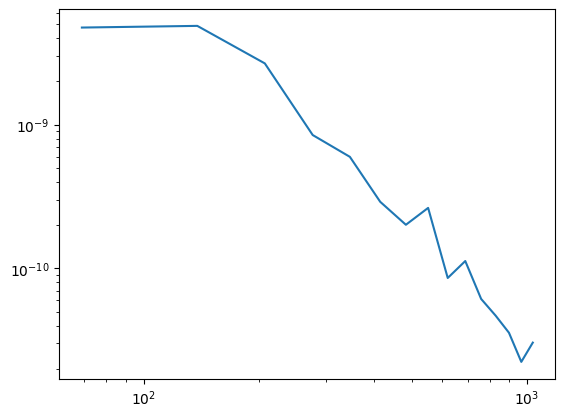

In [32]:
cut = 15
plt.loglog(ell[:cut], clex[:cut])

In [123]:
import numpy as np

fid_cls = np.log(fid_cls)

# get covariance from fiducial sims
C = np.cov(fid_cls.reshape(-1, fid_cls.shape[-1]), rowvar=False)
invC = np.linalg.inv(C)


mu = np.mean(fid_cls, 0)

# next mean of derivatives

# get derivatives
δθ = 2*jnp.array([0.0115, 0.015])
n_param = 2

x_mp = np.log(derv_cls)

# compute finite-differences for derivatives
_dervs = (x_mp[:, 1, :, :] - x_mp[:, 0, :, :]) / np.expand_dims(np.expand_dims(δθ, 0), -1)

mu_dervs = np.mean(_dervs, 0)

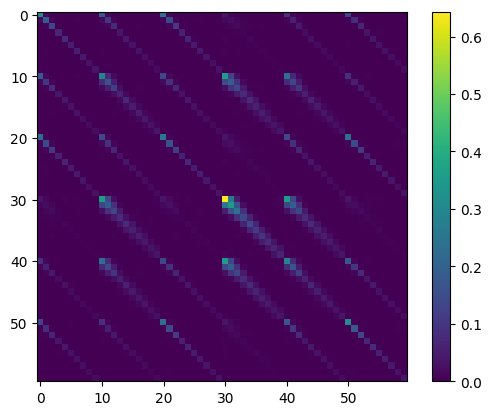

In [124]:
# visualize covariance matrix
plt.imshow((C), vmin=0)
plt.colorbar()

In [125]:
# check that covariance is well-estimated
eigs,evecs = np.linalg.eig(C)
print('minimum eigenvalue', np.min(eigs))
print('maximum eigenvalue', np.max(eigs))

minimum eigenvalue 0.000430830732473951
maximum eigenvalue 1.4579150815354889


In [126]:
F = 0.5 * np.abs(np.einsum("ij,jl,kl->ik", mu_dervs, invC, mu_dervs))

In [127]:
F # lpt1, L500, N256

array([[32599.38599445,  3576.44061422],
       [ 3576.44061422,  1036.64180952]])

In [87]:
F

array([[143330.74504813,   5456.72426063],
       [  5456.72426063,   1508.20848602]])

In [27]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

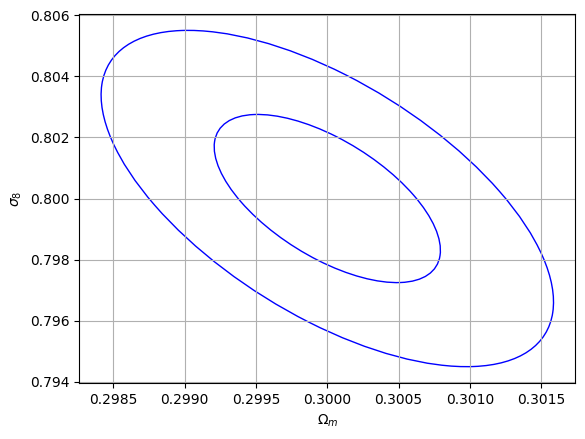

In [28]:
# Example usage:
fisher_matrix = F# Example Fisher information matrix

mean = θ_fid # Example mean vector
plot_fisher_ellipse(fisher_matrix, mean=mean)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\sigma_8$')
#plt.title('Fisher Information Matrix Ellipse')
plt.grid(True)
plt.show()

# lpt=2

### plot all fishers together

In [65]:
lpt_order

2

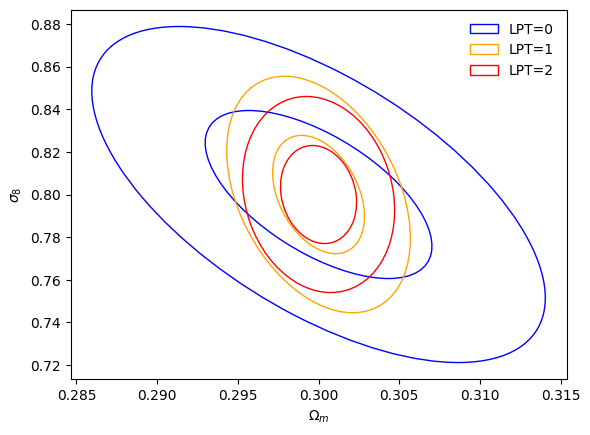

In [128]:
# for 1000 mpc window, L=256
lpt_orders = [0, 1, 2]

F_lpt1_3tomo = np.array([[7481.87735313,  121.0116209 ],
       [ 121.0116209 ,  257.86654146]])

F_lpt1_3tomo_N256 = np.array([[143330.74504813,   5456.72426063],
       [  5456.72426063,   1508.20848602]])

F_lpt2_3tomo_N256 = np.array([[184716.98278826,   3015.6886297 ],
       [  3015.6886297 ,   1941.91558852]]
)

fishers = [
    F,
    F_lpt1_3tomo_N256,
    F_lpt2_3tomo_N256,
]


mean = θ_fid # Example mean vector

colours =["blue", "orange", "red"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label="LPT=%d"%(lpt_orders[i]))
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label="LPT=%d"%(lpt_orders[i]))

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\sigma_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

In [39]:
[0.5*np.log(np.linalg.det(f)) for f in fishers]

[13.40811634250064, 9.521694163330123, 9.836164989709502]

In [476]:
F_lpt1_3tomo = np.array([[7481.87735313,  121.0116209 ],
       [ 121.0116209 ,  257.86654146]])

In [ ]:
F_lpt1_3tomo_N256 = np.array([[[143330.74504813,   5456.72426063],
       [  5456.72426063,   1508.20848602]])

# generate a shitton of simulations over a prior

In [13]:
import jax.random as jrnd

key1 = jrnd.PRNGKey(44)
key2 = jrnd.PRNGKey(45)


num_sims = 5000
key,rng = jrnd.split(key1)

# DIFFERENT RANDOM SEEDS !
omegams = jrnd.uniform(key1, shape=(num_sims,), minval=0.15, maxval=0.7)
sigma8s = jrnd.uniform(key2, shape=(num_sims,), minval=0.5, maxval=1.0)

θ_prior = jnp.stack([omegams, sigma8s], -1)

prior_keys = jnp.arange(num_sims) + 345666



# now make a bunch of simulations (batch in size 50)
batch = 2
input_shape = (4,N,N)

# now fiducial
prior_sims = jnp.zeros((num_sims,) + (input_shape))

# would this compile faster if I just broadcasted the vmap over copies of θ_fid 
mysim = lambda s: simulator(s, θ=θ_fid)
                            
for i in tqdm(range(num_sims // batch)):
    
    #sims = jax.vmap(simulator)(fid_keys[i*batch:(i+1)*batch], jnp.ones((batch, θ_fid.shape[0]))*θ_fid)
    #sims = jax.vmap(mysim)(fid_keys[i*batch:(i+1)*batch])
    #fid.append(sims)

    prior_sims = prior_sims.at[i*batch:(i+1)*batch].set(
                    jax.vmap(simulator)(prior_keys[i*batch:(i+1)*batch], θ_prior[i*batch:(i+1)*batch]))

#prior_sims = jnp.concatenate(prior_sims)

  0%|          | 0/2500 [00:00<?, ?it/s]2024-03-19 22:33:44.307082: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  %slice.535 = s64[16384,512,1]{2,1,0} slice(s64[16384,512,3]{2,1,0} %constant.365), slice={[0:16384], [0:512], [0:1]}, metadata={op_name="jit(simulator)/jit(main)/vmap(jit(all_los))/slice[start_indices=(0, 0, 0) limit_indices=(16384, 512, 1) strides=(1, 1, 1)]" source_file="/tmp/ipykernel_18721/2515812703.py" source_line=47}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-03-19 22:33:58.545030: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation t

In [14]:
outdir = "/data101/makinen/lemur_sims/first_analysis/"

jnp.savez(outdir + "prior_tomo_L_%d_N_%d_Nz_512_LPT%d"%(L, N, lpt_order),
          prior_sims=prior_sims,
          prior_theta=θ_prior
         )

In [15]:
prior_sims.shape

(5000, 4, 128, 128)

In [16]:
outdir = "/data101/makinen/lemur_sims/first_analysis/"
jnp.save(outdir + "prior_tomo_L_%d_N_%d_Nz_512_LPT%d"%(L, N, lpt_order), prior_sims)